# [Public Debt and Low Interest Rates](https://www.aeaweb.org/articles?id=10.1257/aer.109.4.1197)

## Replication of Blanchard (2019)

### by Julien Acalin - Johns Hopkins University

This notebook fully replicates the analysis of the stochastic overlapping generations (OLG) model developed by Blanchard in his presidential address during the AEA meetings 2019. It takes about 3 minutes to run all the simulations in the notebook.

In [2]:
# Some initial setup
#############################

import numpy as np
from numpy import *
from numpy import array
from scipy.optimize import *
from scipy.optimize import minimize_scalar
from scipy import optimize,arange
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from joblib import Parallel, delayed
from scipy.stats import lognorm
import random 
import time
import multiprocessing

start = time.time()

In [3]:
# Linear Production Function
#############################



#############################
# I. Define some functions for the Linear Production Function
#############################

#############################
# a) Factors Returns
#############################

def rK_func(a,b):
    #Eq(14)
    """
    Define Return as Function of Productivity and Previous Capital (Linear)
    """
    return alpha*a

def W_func(a,b):
    #Eq(15)
    """
    Define Wage as Function of Productivity and Previous Capital (Linear)
    """    
    return (1-alpha)*a

def FrK_func(a,b,c):
    """
    Define Next Period (Future) Return as Function of Future Productivity, Previous Capital and Current Investment (Linear)    
    """    
    return alpha*a

def FW_func(a,b,c):
    """
    Define Next Period (Future) Wage as Function of Future Productivity, Previous Capital and Current Investment (Linear)    
    """       
    return (1-alpha)*a

#############################
# b) Transfers Solver
#############################

def SSFast(MPKa,Rfa):
    """
    Steady-State Values without government (Analytical solutions Linear)
    Input: Annual MPK and Rf Rates
    Output: Annual MPK and Rf Rates, mu, gamma, SS Capital, SS Wage
    """      
    #Compute Parameters
    MPK = pow(MPKa/100+1,years)
    Rf  = pow(Rfa/100+1,years)
    #Eq(19)
    gamma = (np.log(MPK) - np.log(Rf))/(sigma*sigma)
    #Eq(18)
    mu = np.log(MPK) - np.log(alpha) - (sigma*sigma)/2 
    
    #Closed form Steady State Values
    #Eq(20)
    KSS = beta*(1-alpha)*(1+l)*np.exp(mu + (sigma*sigma)/2)
    WSS = (1-alpha)*np.exp(mu + (sigma*sigma)/2)

    return (round(MPKa,5), round(Rfa,5), round(mu,2), round(gamma,2), round(KSS,2), round(WSS,2))


def foc(inv,K,W,Xs,gamma,X,tr):
    """
    Define FOC for Investment Linear
    Input: inv (control variable), K, W, Xs, gamma, X (initial endowment), tr (transfer)
    Output: result (which is equal to 0 when FOC holds)
    """     
    num = beta *  pow(pi,-1/2) * sum(weights * (1 + FrK_func(Xs,K,inv) - delta) * (pow((1 + FrK_func(Xs,K,inv) - delta) * inv + (phiret * tauL * FW_func(Xs,K,inv)) + tr ,- gamma)))
    den = pow(pi,-1/2) * sum(weights * pow((1 + FrK_func(Xs,K,inv) - delta) * inv + (phiret * tauL * FW_func(Xs,K,inv)) + tr,1-gamma))
    #Eq(7)
    result = num/den - (1-beta)/(W*(1-tauL) + X - tr - inv) 
    
    return result


def SSValues(MPKa,Rfa,r):
    """
    Steady-State Values (Numerical solutions Linear)
    Input: Annual MPK and Rf Rates, r (repetition index)
    Output: Annual MPK and Rf Rates (Input), mu, gamma, SS Capital, SS Wage, SS Investment, Value function
    """       
    
    #Compute Parameters
    MPK = pow(MPKa/100+1,years)
    Rf  = pow(Rfa/100+1,years)
    #Eq(19)
    gamma = (np.log(MPK) - np.log(Rf))/(sigma*sigma)
    #Eq(18)
    mu = np.log(MPK) - np.log(alpha) - (sigma*sigma)/2 
    Xs = exp(np.sqrt(2)*sigma*nodes+mu) #Gauss-Hermite
        
    #Initialize Model
    i = 0                             #Reset period
    X = l*WSS0list[r]                 #Non-stochastic endowment = l*WSS 
    tr = tau*beta*(1+l)*WSS0list[r]   #Non-stochastic transfer = tau*(1+l)*ISS
    K = beta*(1+l)*WSS0list[r]        #Initial value for K
    W = WSS0list[r]                   #Initial value for W
    I = beta*(1+l)*WSS0list[r]        #Initial value for I
    
    #Create Empty lists
    Klist=[]
    cylist=[]
    Ecolist=[]
    Wlist=[]
    Ilist=[]
    
    while i != periods:
        
        #Current Random Shock
        random.seed(i)  
        np.random.seed(i) 
        z = np.random.lognormal(mu, sigma)
        
        #Old
        Eco = pow(pi,-1/2) * sum(weights * pow(I * (1 + rK_func(Xs,K) - delta) + phiret* tauL * W_func(Xs,K) + tr, 1-gamma))
                
        #Current Wage
        W = W_func(z,K)
            
        #Young Optimal Investment Decision
        I = least_squares(foc, (beta*(1+l)*W), bounds = (0,W*(1-tauL)-tr+X), args=(K,W,Xs,gamma,X,tr,))
        I = round(I.x[0],50)
        cy = W*(1-tauL) -tr - I + X
        
        #Capital Motion
        K = (1 - delta) * K + I
        
        #Build Lists
        Klist.append(K)
        cylist.append(cy)
        Ecolist.append(Eco)
        Wlist.append(W) 
        Ilist.append(I)
        
        i += 1    

    #Compute SS values
    KSS = round(np.mean(Klist[drop:]),50)    
    WSS = round(np.mean(Wlist[drop:]),50)
    ISS = round(np.mean(Ilist[drop:]),50)
        
    #Compute Value function
    cylist = [1] + cylist #Fix consumption for '1st generation' of old when were young to 1
    cylist = cylist[:-1]  #Remove last consumption young to make it consistent   
    Vlong = (1-beta)*np.log(np.asarray(cylist)) + beta / (1-gamma) * np.log(np.asarray(Ecolist))
    V = np.mean(Vlong[drop:])
    
    return (round(MPKa,5), round(Rfa,5), round(mu,2), round(gamma,2), round(KSS,5), round(WSS,5), round(ISS,5), round(V,5))
    

#############################
# c) Debt rollovers Solver
#############################

def Irf(irf,K,W,X,tr,aS,tax):
    """
    Define FOC for Investment and Risk-free rate 
    Input: inv&rf (control variables), K, W, X (initial endowment), tr (transfer), aS (debt level), tax (if default)
    Output: F (which is equal to 0 when FOCs hold)
    """      
    inv = irf[0]
    rf = irf[1]
    
    num = pow(pi,-1/2) * sum(weights * (1 + FrK_func(Xs,K,inv) - delta) * pow( (rf * aS) + (1 + FrK_func(Xs,K,inv) - delta) * inv + tr + phiret * tauL * FW_func(Xs,K,inv), -gamma))
    den1 = pow(pi,-1/2) * sum(weights * pow( (rf * aS) + (1 + FrK_func(Xs,K,inv) - delta) * inv + tr + phiret * tauL * FW_func(Xs,K,inv), 1-gamma))
    den2 = pow(pi,-1/2) * sum(weights * pow( (rf * aS) + (1 + FrK_func(Xs,K,inv) - delta) * inv + tr + phiret * tauL * FW_func(Xs,K,inv), -gamma))
        
    F = empty((2))
    #Eq(2)
    F[0] = ( beta * num ) / ( den1 ) - (1-beta)/(W*(1-tauL) + X - aS - tr - inv - tax)
    #Eq(6)
    F[1] = ( num ) / (  den2 ) - rf
    
    return F


def Rollover(sim):
    """
    Debt Rollovers (Numerical solutions)
    Input: sim (simulation index)
    Output: Capital, Investment, Wage, Annual Rf and MPK Rates, Conso Young, Conso Old, EV Conso Old 
            aS (Safe asset level), aSW (Debt as share of income), taxW (Tax as share of income), aSI (Debt as share of Savings)
    """ 
    
    #Initialize Model
    i = 0                   #Reset period
    rgen=sim*10             #Random number generator
    aS0 = tauaS * ISS       #Initial debt rollover
    aS = aS0                #Initial value for aS
    W = WSS                 #Initial Value for W
    K = KSS                 #Initial value for K
    I = ISS                 #Initial value for I
    X = l*WSS               #Non-stochastic endowment
    tr = tau*beta*(1+l)*WSS #Non-stochastic transfer
    
    #Create Empty lists
    Klist=[]
    Ilist=[]
    Wlist=[]
    rflist=[]
    rKlist=[]
    cylist=[]
    colist=[]    
    Ecolist=[]
    aSlist=[]
    aSWlist=[]
    aSIlist=[]
    taxWlist=[]
    
    while i != generations:
        
        #Current Random Shock
        random.seed(rgen)  
        np.random.seed(rgen) 
        z = np.random.lognormal(mu, sigma)
                
        #Save Values debt ratios
        aSW = aS/(W+X)
        aSI = aS/(I+aS)
        
        #Old consume returns on savings, Transfers, and return on safe asset     
        Eco = pow(pi,-1/2) * sum(weights * pow(I * (1 + rK_func(Xs,K) - delta) + phiret* tauL * W_func(Xs,K) + aS + tr, 1-gamma))
        co = I * (1 + rK_func(z,K) - delta) + phiret* tauL * W_func(z,K) + aS + tr
            
        #Define a tax on young if debt rollover fails
        tax = max(0,aS-upperl*aS0) / max(abs(aS-upperl*aS0),0.000001) * (aS - dtarget*aS0) 
        #Back to dtarget*aS0 if aS>upperl*aS0, equal to aS (ie unchanged) otherwise
        aS = aS - tax 
        
        #Save Values
        taxW = tax/(W+X)
        
        #Young: Use the two optimality conditions to solve for the optimal Investment and consistent Rf        
        res = least_squares(Irf, (beta*(1+l)*W, 1), bounds = ((0, 0), (W*(1-tauL)-aS-tr-tax+X, 2)), args=(K,W,X,tr,aS,tax,))
        #Note: Income = Endowment + Net Labor Income - tax - tr (if fixed transfers) - aS (if rollover debt)
        I = round(res.x[0],50)
        rf = round(res.x[1],50)
        cy = W*(1-tauL) - I - aS - tr - tax + X

        #Store Values
        Klist.append(K)
        Ilist.append(I)
        rflist.append(rf)
        cylist.append(cy)
        colist.append(co)
        Ecolist.append(Eco)
        aSlist.append(aS)
        aSWlist.append(aSW)
        aSIlist.append(aSI)
        taxWlist.append(taxW)        
        
        #Next Period Values
        #Capital Motion
        K = (1 - delta) * K + I
        #Debt Motion
        aS = rf * aS         #Rollover Policy
        #aS = rf * aS + aS0  #Extended Rollover Policy
        
        #Factor Prices    
        W = W_func(z,K)
        rK = rK_func(z,K)
        rKlist.append(rK)
        Wlist.append(W)

        i += 1 
        rgen += 1     
        
    return (Klist, Ilist, Wlist, rflist, rKlist, cylist, colist, Ecolist, aSlist, aSWlist, taxWlist, aSIlist)


#############################
# II. Define the parameters
#############################


#############################
# a) Parameters
#############################

l=1                   #Dummy =0 if no Non-Stochastic Initial Endowment, =1 if NSIC equal to WSS as in Blanchard(2019)
delta = 1             #Depreciation rate
alpha = 1/3           #Capital share in Cobb Douglas
sigma = 0.20          #Std of productivity shock
beta=0.325            #Discount factor (Linear)

years=25              #Length Generation for transfers
periods= 105          #Number simulated periods for transfers
drop=5                #Number of observations to drop for transfers

nsim = 1000           #Number simulations for debt rollovers
generations = 6       #Number generations for debt rollovers
upperl = 1.15         #Upper limit for Default
dtarget = 0.4         #Target value of Debt after Default

#############################
# b) Define the range values for MPK and EP (Transfers)
#############################

#rf = [1, 0.5, 0, -0.5, -1, -1.5, -2]
#mpk = [2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0]

rf = [1, 0.5, 0, -0.5, -1, -1.5, -2]
mpk = [4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0]

#############################
# c) Keep one specification (Debt rollovers)
#############################

MPKax = 2
Rfax = -1

#############################
# d) Computes the sample points and weights for Gauss-Hermite quadrature
#############################

degrees=100
nodes = np.polynomial.hermite.hermgauss(degrees)[0]
weights = np.polynomial.hermite.hermgauss(degrees)[1]



#############################
# III. Solve Transfers
#############################

#############################
# a) Solve for Analytical SS values without Government
#############################

#Solve Model for the range of values for MPK and EP
output_short=[]
for i in mpk:
    for j in rf:
        if j > i:
            continue 
        out=SSFast(i, j)
        output_short.append(out)

#Store Results
MPKa0list = array(output_short)[:,0]
Rfa0list = array(output_short)[:,1]
mu0list = array(output_short)[:,2] 
gamma0list = array(output_short)[:,3]
KSS0list = array(output_short)[:,4]
WSS0list = array(output_short)[:,5]

#Number calibrations
x = len(KSS0list)
x = list(range(0, x))

#############################
# b) Solve for Numerical SS values without Government
#############################

#No Government
aS = 0                 #Safe assets (government debt)
tauL = 0.0             #Tax rate on labor
tau = 0                #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model for the range of values for MPK and EP
num_cores = multiprocessing.cpu_count()
calibration = Parallel(n_jobs=num_cores)(delayed(SSValues)(MPKa=MPKa0list[i], Rfa=Rfa0list[i], r=i) for i in x)                  

#Save Results
#np.savetxt("calibrationLinear.csv", calibration, delimiter=",", fmt='%s')

#Store Results
MPKalist = array(calibration)[:,0]
Rfalist  = array(calibration)[:,1]
mulist = array(calibration)[:,2]
gammalist= array(calibration)[:,3]
KSSlist = array(calibration)[:,4]
WSSlist = array(calibration)[:,5]
ISSlist = array(calibration)[:,6]
Vlist = array(calibration)[:,7]

#############################
# c) Solve for Numerical SS values with Government - 5% of ISS
#############################

#Government
aS = 0                 #Safe assets (government debt)
tauL = 0.0             #Tax rate on labor
tau = 0.05             #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model for the range of values for MPK and EP
num_cores = multiprocessing.cpu_count()
result1 = Parallel(n_jobs=num_cores)(delayed(SSValues)(MPKa=MPKa0list[i], Rfa=Rfa0list[i], r=i) for i in x)                  

#Make lists
Vlisttr5ISS = array(result1)[:,7]


#############################
# d) Solve for Numerical SS values with Government - 20% of ISS
#############################

#Government
aS = 0                 #Safe assets (government debt)
tauL = 0.0             #Tax rate on labor
tau = 0.20             #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model for the range of values for MPK and EP
num_cores = multiprocessing.cpu_count()
result2 = Parallel(n_jobs=num_cores)(delayed(SSValues)(MPKa=MPKa0list[i], Rfa=Rfa0list[i], r=i) for i in x)                  

#Make lists
Vlisttr20ISS = array(result2)[:,7]


#############################
# e) Save Results
#############################

#Save Results
resL = [Vlist, (Vlisttr5ISS-Vlist)*100, (Vlisttr20ISS-Vlist)*100, MPKa0list, Rfa0list]
#np.savetxt("resultsLinear.csv", resL, delimiter=",", fmt='%s')


#############################
# IV. Solve Debt Rollovers
#############################

#############################
# a) Keep one specification for Debt rollovers
#############################

list_output = [item for item in calibration if item[0] < MPKax+0.05 and item[0] > MPKax-0.05]
list_output = [item for item in list_output if item[1] < Rfax+0.05 and item[1] > Rfax-0.05]
output_short = list_output

#Make lists Steady State Values without Government
MPKa = array(output_short)[0,0]
Rfa  = array(output_short)[0,1]
mu = array(output_short)[0,2]      
Xs = exp(np.sqrt(2)*sigma*nodes+mu) 
gamma= array(output_short)[0,3]
KSS = array(output_short)[0,4]
WSS = array(output_short)[0,5]
ISS = array(output_short)[0,6]
ISSL = ISS
V = array(output_short)[0,7]


#############################
# b) Solve for Numerical SS values without Government
#############################

#No Government
tauaS = 0              #Initial debt rollover as share of ISS 
tauL = 0.00            #Tax rate on labor
tau = 0.00             #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model
DRcalibration=Parallel(n_jobs=num_cores)(delayed(Rollover)(i) for i in range(nsim))  

#Format Results
DRcalibration=asarray(DRcalibration)

#Store Results
KM0 = DRcalibration[:,0,:]
IM0 = DRcalibration[:,1,:]
WM0 = DRcalibration[:,2,:]
rfM0 = DRcalibration[:,3,:]
rKM0 = DRcalibration[:,4,:]
cyM0 = DRcalibration[:,5,:]
coM0 = DRcalibration[:,6,:]
EcoM0 = DRcalibration[:,7,:]
aSM0 = DRcalibration[:,8,:]
aSWM0 = DRcalibration[:,9,:]
taxWM0 = DRcalibration[:,10,:]
aSIM0 = DRcalibration[:,11,:]

#Compute Expected Utility
aS0 = tauaS * ISS
EcoM0 = EcoM0[:,1:] #Remove first Expected consumption old in all simulations to make it time consistent
cyM0 = cyM0[:,0:-1] #Remove last consumption young in all simulations to make it time consistent
Vb0 = (1-beta)*np.log(np.asarray(cyM0)) + beta / (1-gamma) * np.log(np.asarray(EcoM0))
cold = np.log(pow(MPKa/100+1,25)*KSS + aS0)
VbL0 = np.insert(Vb0, 0, cold, axis=1) #Fix value function for 1st generation of old in all simulations
Vb0_mean = np.mean(Vb0, axis=0)


#############################
# c) Solve for Numerical SS values with Government
#############################

#No Government
tauaS = 0.15           #Initial debt rollover as share of ISS 
tauL = 0.00            #Tax rate on labor
tau = 0.00             #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model
DRcalibration=Parallel(n_jobs=num_cores)(delayed(Rollover)(i) for i in range(nsim))  

#Fornat Results
DRcalibration=asarray(DRcalibration)

#Store Results
KM = DRcalibration[:,0,:]
IM = DRcalibration[:,1,:]
WM = DRcalibration[:,2,:]
rfM = DRcalibration[:,3,:]
rKM = DRcalibration[:,4,:]
cyM = DRcalibration[:,5,:]
coM = DRcalibration[:,6,:]
EcoM = DRcalibration[:,7,:]
aSM = DRcalibration[:,8,:]
aSWM = DRcalibration[:,9,:]
taxWM = DRcalibration[:,10,:]
aSIL = DRcalibration[:,11,:]

#Compute Expected Utility
aS0 = tauaS * ISS
EcoM = EcoM[:,1:] #Remove first Expected consumption old in all simulations to make it time consistent
cyM = cyM[:,0:-1] #Remove last consumption young in all simulations to make it time consistent
Vb = (1-beta)*np.log(np.asarray(cyM)) + beta / (1-gamma) * np.log(np.asarray(EcoM))
cold = np.log(pow(MPKa/100+1,25)*KSS + aS0)
VbL = np.insert(Vb, 0, cold, axis=1) #Fix value function for 1st generation of old in all simulations
Vb_mean = np.mean(Vb, axis=0)


In [4]:
# Cobb-Douglas Production Function
#############################



#############################
# I. Define some functions for the Cobb-Douglas Production Function
#############################

#############################
# a) Factors Returns
#############################

def rK_func(a,b):
    #Eq(22)
    """
    Define Return as Function of Productivity and Previous Capital (Cobb-Douglas)
    """
    return alpha*a*pow(b,alpha-1)

def W_func(a,b):
    #Eq(23)
    """
    Define Wage as Function of Productivity and Previous Capital (Cobb-Douglas)
    """    
    return (1-alpha)*a*pow(b,alpha)

def FrK_func(a,b,c):
    """
    Define Next Period (Future) Return as Function of Future Productivity, Previous Capital and Current Investment (Cobb-Douglas)    
    """    
    return alpha*a*pow((1 - delta)*b+c,alpha-1)

def FW_func(a,b,c):
    """
    Define Next Period (Future) Wage as Function of Future Productivity, Previous Capital and Current Investment (Cobb-Douglas)    
    """       
    return (1-alpha)*a*pow((1 - delta)*b+c,alpha)


#############################
# b) Transfers Solver
#############################

def SSFast(MPKa,Rfa):
    """
    Steady-State Values without government (Analytical solutions Cobb-Douglas)
    Input: Annual MPK and Rf Rates
    Output: Annual MPK and Rf Rates, beta, gamma, SS Capital, SS Wage, test=0
    """      
    #Compute Parameters
    #[Add References]
    MPK = pow(MPKa/100+1,years)
    Rf  = pow(Rfa/100+1,years)
    #Eq(36)
    gamma = (np.log(MPK) - np.log(Rf))/(sigma*sigma)
    #Eq(35)
    beta = alpha / (MPK/np.exp(sigma*sigma/(1+alpha))) / ((1-alpha)*(1+l))
    
    #Closed form Steady State Values
    #Eq(30)
    KSS = np.exp((np.log(beta*(1+l)*(1-alpha))+mu)/(1-alpha) + (sigma*sigma)/(2*(1-alpha*alpha)))
    WSS = (1-alpha)*np.exp(mu + sigma*sigma/2)*np.exp((np.log(beta*(1+l)*(1-alpha))+mu)/(1-alpha)*alpha + (sigma*sigma)*(alpha*alpha)/(2*(1-alpha*alpha)))

    return (round(MPKa,5), round(Rfa,5), round(beta,2), round(gamma,2), round(KSS,2), round(WSS,2))


def foc(inv,K,W,beta,gamma,X,tr):
    """
    Define FOC for Investment Cobb-Douglas
    Input: inv (control variable), K, W, beta, gamma, X (initial endowment), tr (transfer)
    Output: result (which is equal to 0 when FOC holds)
    """     
    num = beta *  pow(pi,-1/2) * sum(weights * (1 + FrK_func(Xs,K,inv) - delta) * (pow((1 + FrK_func(Xs,K,inv) - delta) * inv + (phiret * tauL * FW_func(Xs,K,inv)) + tr ,- gamma)))
    den = pow(pi,-1/2) * sum(weights * pow((1 + FrK_func(Xs,K,inv) - delta) * inv + (phiret * tauL * FW_func(Xs,K,inv)) + tr,1-gamma))
    #Eq(7)
    result = num/den - (1-beta)/(W*(1-tauL) + X - tr - inv) 
    
    return result


def SSValues(MPKa,Rfa,r):
    """
    Steady-State Values (Numerical solutions Cobb-Douglas beta)
    Input: Annual MPK and Rf Rates, r (repetition index)
    Output: Annual MPK and Rf Rates (Input), beta, gamma, SS Capital, SS Wage, SS Investment, Value function
    """       
    
    #Compute Parameters
    MPK = pow(MPKa/100+1,years)
    Rf  = pow(Rfa/100+1,years)
    #Eq(36)
    gamma = (np.log(MPK) - np.log(Rf))/(sigma*sigma)
    #Eq(35)
    beta = alpha / (MPK/np.exp(sigma*sigma/(1+alpha))) / ((1-alpha)*(1+l))
    
    #Initialize Model
    i = 0                             #Reset period
    X = l*WSS0list[r]                 #Non-stochastic endowment = l*WSS 
    tr = tau*beta*(1+l)*WSS0list[r]   #Non-stochastic transfer = tau*(1+l)*ISS
    K = beta*(1+l)*WSS0list[r]        #Initial value for K
    W = WSS0list[r]                   #Initial value for W
    I = beta*(1+l)*WSS0list[r]        #Initial value for I
    
    #Create Empty lists
    Klist=[]
    cylist=[]
    Ecolist=[]
    Wlist=[]
    Ilist=[]
    
    while i != periods:
        
        #Current Random Shock
        random.seed(i)  
        np.random.seed(i) 
        z = np.random.lognormal(mu, sigma)
        
        #Old
        Eco = pow(pi,-1/2) * sum(weights * pow(I * (1 + rK_func(Xs,K) - delta) + phiret* tauL * W_func(Xs,K) + tr, 1-gamma))
   
        #Current Wage
        W = W_func(z,K)
            
        #Young Optimal Investment Decision
        I = least_squares(foc, (beta*(1+l)*W), bounds = (0,W*(1-tauL)-tr+X), args=(K,W,beta,gamma,X,tr,)) #Cobb-Douglas
        I = round(I.x[0],50)
        cy = W*(1-tauL) -tr - I + X
        
        #Capital Motion
        K = (1 - delta) * K + I
        
        #Build Lists
        Klist.append(K)
        cylist.append(cy)
        Ecolist.append(Eco)
        Wlist.append(W) 
        Ilist.append(I)
        
        i += 1    

    #Compute SS values
    KSS = round(np.mean(Klist[drop:]),50)    
    WSS = round(np.mean(Wlist[drop:]),50)
    ISS = round(np.mean(Ilist[drop:]),50)
        
    #Compute Value function
    cylist = [1] + cylist #Fix consumption for '1st generation' of old when were young to 1
    cylist = cylist[:-1]  #Remove last consumption young to make it consistent   
    Vlong = (1-beta)*np.log(np.asarray(cylist)) + beta / (1-gamma) * np.log(np.asarray(Ecolist))
    V = np.mean(Vlong[drop:])
    
    return (round(MPKa,5), round(Rfa,5), round(beta,2), round(gamma,2), round(KSS,5), round(WSS,5), round(ISS,5), round(V,5))
    
    
#############################
# c) Debt rollovers Solver
#############################

def Irf(irf,K,W,X,tr,aS,tax):
    """
    Define FOC for Investment and Risk-free rate 
    Input: inv&rf (control variables), K, W, X (initial endowment), tr (transfer), aS (debt level), tax (if default)
    Output: F (which is equal to 0 when FOCs hold)
    """      
    inv = irf[0]
    rf = irf[1]
    
    num = pow(pi,-1/2) * sum(weights * (1 + FrK_func(Xs,K,inv) - delta) * pow( (rf * aS) + (1 + FrK_func(Xs,K,inv) - delta) * inv + tr + phiret * tauL * FW_func(Xs,K,inv), -gamma))
    den1 = pow(pi,-1/2) * sum(weights * pow( (rf * aS) + (1 + FrK_func(Xs,K,inv) - delta) * inv + tr + phiret * tauL * FW_func(Xs,K,inv), 1-gamma))
    den2 = pow(pi,-1/2) * sum(weights * pow( (rf * aS) + (1 + FrK_func(Xs,K,inv) - delta) * inv + tr + phiret * tauL * FW_func(Xs,K,inv), -gamma))
        
    F = empty((2))
    #Eq(2)
    F[0] = ( beta * num ) / ( den1 ) - (1-beta)/(W*(1-tauL) + X - aS - tr - inv - tax)
    #Eq(6)
    F[1] = ( num ) / (  den2 ) - rf
    
    return F


def Rollover(sim):
    """
    Debt Rollovers (Numerical solutions)
    Input: sim (simulation index)
    Output: Capital, Investment, Wage, Annual Rf and MPK Rates, Conso Young, Conso Old, EV Conso Old 
            aS (Safe asset level), aSW (Debt as share of income), taxW (Tax as share of income), aSI (Debt as share of Savings)
    """ 
    
    #Initialize Model
    rgen=sim*10             #Random number generator
    aS0 = tauaS * ISS       #Initial debt rollover
    aS = aS0                #Initial value for aS
    i = 0                   #Reset period
    W = WSS                 #Initial Value for W
    K = KSS                 #Initial value for K
    I = ISS                 #Initial value for I
    X = l*WSS               #Non-stochastic endowment
    tr = tau*beta*(1+l)*WSS #Non-stochastic transfer
    
    #Create Empty lists
    Klist=[]
    Ilist=[]
    Wlist=[]
    rflist=[]
    rKlist=[]
    cylist=[]
    colist=[]    
    Ecolist=[]
    aSlist=[]
    aSWlist=[]
    aSIlist=[]
    taxWlist=[]
    
    while i != generations:
        
        #Current Random Shock
        random.seed(rgen)  
        np.random.seed(rgen) 
        z = np.random.lognormal(mu, sigma)
                
        #Save Values
        aSW = aS/(W+X)
        aSI = aS/(I+aS)
        
        #Old consume returns on savings, Transfers, and return on safe asset     
        Eco = pow(pi,-1/2) * sum(weights * pow(I * (1 + rK_func(Xs,K) - delta) + phiret* tauL * W_func(Xs,K) + aS + tr, 1-gamma))
        co = I * (1 + rK_func(z,K) - delta) + phiret* tauL * W_func(z,K) + aS + tr

        #Define a tax on young if debt rollover fails
        tax = max(0,aS-upperl*aS0) / max(abs(aS-upperl*aS0),0.000001) * (aS - dtarget*aS0) 
        #Back to dtarget*aS0 if aS>upperl*aS0, equal to aS (ie unchanged) otherwise
        aS = aS - tax 
        
        #Save Values
        taxW = tax/(W+X)
        
        #Young: Use the two optimality conditions to solve for the optimal Investment and consistent Rf        
        res = least_squares(Irf, (beta*(1+l)*W, 1), bounds = ((0, 0), (W*(1-tauL)-aS-tr-tax+X, 2)), args=(K,W,X,tr,aS,tax,))
        #Note: Income = Endowment + Net Labor Income - tax - tr (if fixed transfers) - aS (if rollover debt)
        I = round(res.x[0],50)
        rf = round(res.x[1],50)
        cy = W*(1-tauL) - I - aS - tr - tax + X

        #Store Values
        Klist.append(K)
        Ilist.append(I)
        rflist.append(rf)
        cylist.append(cy)
        colist.append(co)
        Ecolist.append(Eco)
        aSlist.append(aS)
        aSWlist.append(aSW)
        aSIlist.append(aSI)
        taxWlist.append(taxW)        
        
        #Next Period Values
        #Capital Motion
        K = (1 - delta) * K + I
        #Debt Motion
        aS = rf * aS         #Rollover Policy
        #aS = rf * aS + aS0  #Extended Rollover Policy
        
        #Factor Prices    
        W = W_func(z,K)
        rK = rK_func(z,K)
        
        rKlist.append(rK)
        Wlist.append(W)

        i += 1 
        rgen += 1     
        
    return (Klist, Ilist, Wlist, rflist, rKlist, cylist, colist, Ecolist, aSlist, aSWlist, taxWlist, aSIlist)


#############################
# II. Define the parameters
#############################

#############################
# a) Parameters
#############################

l=1                   #Dummy =0 if no Non-Stochastic Initial Endowment, =1 if NSIC equal to WSS as in Blanchard(2019)
delta = 1             #Depreciation rate
alpha = 1/3           #Capital share in Cobb Douglas
sigma = 0.20          #Std of productivity shock
mu = 3                #Mean of productivity shock (Cobb-Douglas)

years=25              #Length Generation for transfers
periods= 105          #Number simulated periods for transfers
drop=5                #Number of observations to drop for transfers

nsim = 1000           #Number simulations for debt rollovers
generations = 6       #Number generations for debt rollovers
upperl = 1.15         #Upper limit for Default
dtarget = 0.4         #Target value of Debt after Default

#############################
# b) Define the range values for MPK and EP (Transfers)
#############################

#rf = [1, 0.5, 0, -0.5, -1, -1.5, -2]
#mpk = [2.5, 2.25, 2, 1.75, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0]

rf = [1, 0.5, 0, -0.5, -1, -1.5, -2]
mpk = [4, 3.5, 3, 2.5, 2, 1.5, 1, 0.5, 0]

#############################
# c) Keep one specification (Debt rollovers)
#############################

MPKax = 2
Rfax = -1

#############################
# d) Computes the sample points and weights for Gauss-Hermite quadrature
#############################

degrees=100
nodes = np.polynomial.hermite.hermgauss(degrees)[0]
weights = np.polynomial.hermite.hermgauss(degrees)[1]
Xs = exp(np.sqrt(2)*sigma*nodes+mu)



#############################
# III. Solve Transfers
#############################


#############################
# a) Solve for Analytical SS values without Government
#############################

#Solve Model for the range of values for MPK and EP
output_short=[]
for i in mpk:
    for j in rf:
        if j > i:
            continue 
        out=SSFast(i, j)
        output_short.append(out)

#Store Results
MPKa0list = array(output_short)[:,0]
Rfa0list = array(output_short)[:,1]
beta0list = array(output_short)[:,2] 
gamma0list = array(output_short)[:,3]
KSS0list = array(output_short)[:,4]
WSS0list = array(output_short)[:,5]

#Number calibrations
x = len(KSS0list)
x = list(range(0, x))

#############################
# b) Solve for Numerical SS values without Government
#############################

#No Government
aS = 0                 #Safe assets (government debt)
tauL = 0.0             #Tax rate on labor
tau = 0                #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model for the range of values for MPK and EP
num_cores = multiprocessing.cpu_count()
calibration = Parallel(n_jobs=num_cores)(delayed(SSValues)(MPKa=MPKa0list[i], Rfa=Rfa0list[i], r=i) for i in x)                  

#Save Results
#np.savetxt("calibrationCobbDouglas.csv", calibration, delimiter=",", fmt='%s')

#Store Results
MPKalist = array(calibration)[:,0]
Rfalist  = array(calibration)[:,1]
betalist = array(calibration)[:,2]
gammalist= array(calibration)[:,3]
KSSlist = array(calibration)[:,4]
WSSlist = array(calibration)[:,5]
ISSlist = array(calibration)[:,6]
Vlist = array(calibration)[:,7]

#############################
# c) Solve for Numerical SS values with Government - 5% of ISS
#############################

#Government
aS = 0                 #Safe assets (government debt)
tauL = 0.0             #Tax rate on labor
tau = 0.05             #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model for the range of values for MPK and EP
num_cores = multiprocessing.cpu_count()
result1 = Parallel(n_jobs=num_cores)(delayed(SSValues)(MPKa=MPKa0list[i], Rfa=Rfa0list[i], r=i) for i in x)                  

#Make lists
Vlisttr5ISS = array(result1)[:,7]


#############################
# d) Solve for Numerical SS values with Government - 20% of ISS
#############################

#Government
aS = 0                 #Safe assets (government debt)
tauL = 0.0             #Tax rate on labor
tau = 0.20             #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model for the range of values for MPK and EP
num_cores = multiprocessing.cpu_count()
result2 = Parallel(n_jobs=num_cores)(delayed(SSValues)(MPKa=MPKa0list[i], Rfa=Rfa0list[i], r=i) for i in x)                  

#Make lists
Vlisttr20ISS = array(result2)[:,7]


#############################
# e) Save All Results
#############################

#Save Results
resCD = [Vlist, (Vlisttr5ISS-Vlist)*100, (Vlisttr20ISS-Vlist)*100, MPKa0list, Rfa0list]
#np.savetxt("resultsCobbDouglas.csv", resCD, delimiter=",", fmt='%s')


#############################
# IV. Solve Debt Rollovers
#############################

#############################
# a) Keep one specification for Debt rollovers
#############################

list_output = [item for item in calibration if item[0] < MPKax+0.05 and item[0] > MPKax-0.05]
list_output = [item for item in list_output if item[1] < Rfax+0.05 and item[1] > Rfax-0.05]
output_short = list_output

#Make lists Steady State Values without Government
MPKa = array(output_short)[0,0]
Rfa  = array(output_short)[0,1]
beta = array(output_short)[0,2]      
gamma= array(output_short)[0,3]
KSS = array(output_short)[0,4]
WSS = array(output_short)[0,5]
ISS = array(output_short)[0,6]
ISSCD = ISS
V = array(output_short)[0,7]


#############################
# b) Solve for Numerical SS values without Government
#############################

#No Government
tauaS = 0              #Initial debt rollover as share of ISS 
tauL = 0.00            #Tax rate on labor
tau = 0.00             #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model
DRcalibration=Parallel(n_jobs=num_cores)(delayed(Rollover)(i) for i in range(nsim))  

#Format Results
DRcalibration=asarray(DRcalibration)

#Store Results
KM0 = DRcalibration[:,0,:]
IM0 = DRcalibration[:,1,:]
WM0 = DRcalibration[:,2,:]
rfM0 = DRcalibration[:,3,:]
rKM0 = DRcalibration[:,4,:]
cyM0 = DRcalibration[:,5,:]
coM0 = DRcalibration[:,6,:]
EcoM0 = DRcalibration[:,7,:]
aSM0 = DRcalibration[:,8,:]
aSWM0 = DRcalibration[:,9,:]
taxWM0 = DRcalibration[:,10,:]
aSIM0 = DRcalibration[:,11,:]

#Compute Expected Utility
aS0 = tauaS * ISS
EcoM0 = EcoM0[:,1:] #Remove first Expected consumption old in all simulations to make it time consistent
cyM0 = cyM0[:,0:-1] #Remove last consumption young in all simulations to make it time consistent
Vb0 = (1-beta)*np.log(np.asarray(cyM0)) + beta / (1-gamma) * np.log(np.asarray(EcoM0))
cold = np.log(pow(MPKa/100+1,25)*KSS + aS0)
VbCD0 = np.insert(Vb0, 0, cold, axis=1) #Fix value function for 1st generation of old in all simulations
Vb0_mean = np.mean(Vb0, axis=0)


#############################
# c) Solve for Numerical SS values with Government
#############################

#No Government
tauaS = 0.15          #Initial debt rollover as share of ISS 
tauL = 0.00            #Tax rate on labor
tau = 0.00             #Transfers rate
phiret = 1             #Share of government spending allocated to old

#Solve Model
DRcalibration=Parallel(n_jobs=num_cores)(delayed(Rollover)(i) for i in range(nsim))  

#Fornat Results
DRcalibration=asarray(DRcalibration)

#Store Results
KM = DRcalibration[:,0,:]
IM = DRcalibration[:,1,:]
WM = DRcalibration[:,2,:]
rfM = DRcalibration[:,3,:]
rKM = DRcalibration[:,4,:]
cyM = DRcalibration[:,5,:]
coM = DRcalibration[:,6,:]
EcoM = DRcalibration[:,7,:]
aSM = DRcalibration[:,8,:]
aSWM = DRcalibration[:,9,:]
taxWM = DRcalibration[:,10,:]
aSICD = DRcalibration[:,11,:]

#Compute Expected Utility
aS0 = tauaS * ISS
EcoM = EcoM[:,1:] #Remove first Expected consumption old in all simulations to make it time consistent
cyM = cyM[:,0:-1] #Remove last consumption young in all simulations to make it time consistent
Vb = (1-beta)*np.log(np.asarray(cyM)) + beta / (1-gamma) * np.log(np.asarray(EcoM))
cold = np.log(pow(MPKa/100+1,25)*KSS + aS0)
VbCD = np.insert(Vb, 0, cold, axis=1) #Fix value function for 1st generation of old in all simulations
Vb_mean = np.mean(Vb, axis=0)


## Introduction

The paper focuses on the fiscal and welfare costs of public debt when safe interest rates are low. It shows how both the average risky rate and the average safe rate determine welfare outcomes.

**First, the paper looks at the effects of an intergenerational transfer in an overlapping generation model with uncertainty.** As in the Diamond model, a transfer has two effects on welfare: an effect through reduced capital accumulation, and an indirect effect, through the induced change in the returns to labor and capital. The welfare effect through lower capital accumulation depends on the safe rate. It is positive if, on average, the safe rate is less than the growth rate. The intuitive reason is that, in effect, the safe rate is the relevant risk-adjusted rate of return on capital, thus it is the rate that must be compared to the growth rate. The welfare effect through the induced change in returns to labor and capital depends instead on the average (risky) marginal product of capital. It is negative if, on average, the marginal product of capital exceeds the growth rate. **Thus, in the current situation where it indeed appears that the safe rate is less than the growth rate, but the average marginal product of capital exceeds the growth rate, the two effects have opposite signs, and the effect of the transfer on welfare is ambiguous.**

**Second, the paper turns to debt and shows that a debt rollover differs in two ways from a transfer scheme.** First, with respect to feasibility: so long as the safe rate remains less than the growth rate, the ratio of debt to GDP decreases over time; a sequence of adverse shocks may however increase the safe rate sufficiently so as to lead to explosive dynamics, with higher debt increasing the safe rate, and the higher safe rate in turn increasing debt over time. Second, with respect to desirability: a successful debt rollover can yield positive welfare effects, but less so than the transfer scheme. The reason is that a debt
rollover pays people a lower rate of return than the implicit rate in the transfer scheme.


## The Model

This section presents the model. More details about the model can be found in [Blanchard (2019)](https://www.aeaweb.org/aea/2019conference/program/pdf/14020_paper_etZgfbDr.pdf)  
The derivations can be found [here](https://www.aeaweb.org/aea/2019conference/program/pdf/14020_paper_etZgfbDr.pdf).


**Assumptions**

People live for two periods, working in the first, and retiring in the second. They have separate preferences vis-à-vis intertemporal substitution and risk. This allows to look at different combinations of risky and safe rates, depending on the degree of uncertainty and the degree of risk aversion. Production is constant elasticity of substitution (CES) in
labor and capital, and subject to technological shocks; being able to vary the elasticity of substitution between capital and labor turns out to be important as this elasticity determines the strength of the indirect effect on welfare. There is no technological progress, nor population growth, so the average growth rate is equal to zero.

Each of the two periods of life are equal to 25 years. Given the role of risk aversion in determining the gap between the average safe and risky rates, we want to separate the elasticity of substitution across the two periods of life and the degree
of risk aversion. Thus, we assume the representative agent maximizes an Epstein-Zin utility function:

$$
\mathbb{U}_t = (1-\beta)u\left(C^y_{t}\right)+ \frac{\beta}{1-\gamma}  u( \mathbb{E}_{t} \left[ (C^o_{t+1})^{1-\gamma} \right])
$$

Where: $u(C) = \log(C)$

The log-log specification implies that the intertemporal elasticity of substitution is equal to 1. The coefficient of relative risk aversion is given by $\gamma$.


With respect to:
$$
\begin{aligned} C^y_{t}+ I_{t} + D_t &=W_{t} + X -T_t \\ K_{t} &=I_{t} + (1-\delta) K_{t-1} \\ C^o_{t+1} &=R_{t+1}K_{t} +R^f_{t}D_t+T_{t+1} \\ 
Y_t &= A_t F(K_{t-1},L_t) \\ \log \left(A\right) & \sim \mathcal{N}(\mu, \sigma) \end{aligned}
$$

Where $C^y_{t}$ and $C^o_{t+1}$ respectively denote consumption when young and old, $I_t$ is investment in physical capital, $D_t$ is investment in the safe asset (sovereign debt), $W_t$ is the wage, $X$ is an initial non-stochastic endowment, $T_t$ and $T_{t+1}$ denote inter-generational transfers, $A_t$ is a log-normally distributed productivity shock, and $R_{t+1}$ and $R^f_t$ denote respectively the return to physical capital and risk-free asset. Assume that there is full depreciation after one period ($\delta=1$) so that $K_t=I_t$.

Given that the wage follows a log normal distribution and thus can be arbitrarily small, the endowment $X$ is needed to make sure that the deterministic transfer from the young to the old is always feasible, no matter what the realization of W. We assume that the endowment is equal to 100 percent of the average wage absent the transfer.


Factors earn their marginal return:
$$
\begin{aligned} W_t &= A_t F_L (K_{t-1},L_t)  \\ R_t &= A_t F_K (K_{t-1},L_t) \end{aligned}
$$

In the baseline scenario, there is no government intervention: $T_t=D_t=0$ $\forall t$. 



**The paper discusses the welfare implications of two types of policy intervention: **
- The government can start a social security system and sets the level of Transfers $T_t$ accordingly.
- Alternatively, the government can start to issue and Rollover Debt $D_t$.

## Welfare implications of Transfers (Long-run)

**This section discusses the effects on steady-state welfare of an intergenerational transfer.**

### Linear Production Function

**Figure 1** shows the effects of a small transfer (5 percent of (pre-transfer) average saving) on welfare for the different combinations of the safe and the risky rates (reported, for convenience, as net rates at annual values, rather than as gross rates at 25-year values), in the case production is linear. Welfare increases if the safe rate is negative (more precisely, if it is below the growth rate, here equal to 0), no matter what the average risky rate.


**Figure 2** looks at a larger transfer (20 percent of saving), again in the linear production case. For a given ERf, a larger ER leads to a smaller welfare increase if welfare increases, and to a larger welfare decrease if welfare decreases. 
 

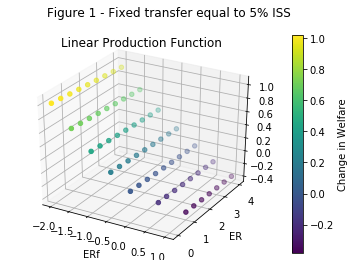

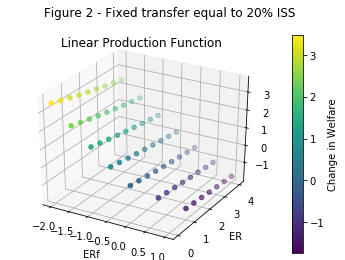

In [5]:
# Plot All Results Welfare
#############################

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('ERf')
plt.ylabel('ER')
pnt3d=ax.scatter(resL[4],resL[3],resL[1],c=resL[1])
cbar=plt.colorbar(pnt3d)
cbar.set_label("Change in Welfare")
plt.suptitle('Figure 1 - Fixed transfer equal to 5% ISS')
plt.title('Linear Production Function')
#plt.savefig('Fig1.png')
plt.show()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('ERf')
plt.ylabel('ER')
pnt3d=ax.scatter(resL[4],resL[3],resL[2],c=resL[2])
cbar=plt.colorbar(pnt3d)
cbar.set_label("Change in Welfare")
plt.suptitle('Figure 2 - Fixed transfer equal to 20% ISS')
plt.title('Linear Production Function')
#plt.savefig('Fig2.png')
plt.show()

### Cobb-Douglas Production Function

**Figures 3 and 4** do the same, but now for the Cobb-Douglas case. They yield the following conclusions. Both effects are now at work, and both rates matter. A lower safe rate makes it more likely that the transfer will increase welfare; a higher risky rate makes it less likely. 

For a small transfer (5 percent of saving), a safe rate 2 percent lower than the growth rate leads to an increase in welfare so long as the risky rate is less than 2 percent above the growth rate. A safe rate 1 percent lower than the growth rate leads to an increase in welfare so long as the risky rate is less than 1 percent above the growth rate. 

For a larger transfer (20 percent of saving), which increases the average Rf closer to 1, the trade-off becomes less attractive. For welfare to increase, a safe rate 2 percent lower than the growth rate requires that the risky rate be less than 1.5 percent above the growth rate; a safe rate of 1 percent below the growth rate requires that the risky rate be less than 0.7 percent above the growth rate.


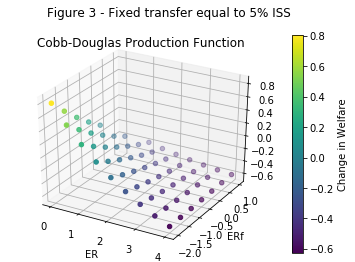

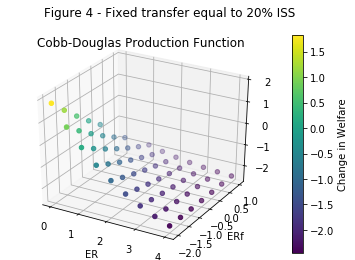

In [6]:
# Plot All Results Welfare
#############################

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('ER')
plt.ylabel('ERf')
pnt3d=ax.scatter(resCD[3],resCD[4],resCD[1],c=resCD[1])
cbar=plt.colorbar(pnt3d)
cbar.set_label("Change in Welfare")
plt.suptitle('Figure 3 - Fixed transfer equal to 5% ISS')
plt.title('Cobb-Douglas Production Function')
#plt.savefig('Fig3.png')
plt.show()

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
plt.xlabel('ER')
plt.ylabel('ERf')
pnt3d=ax.scatter(resCD[3],resCD[4],resCD[2],c=resCD[2])
cbar=plt.colorbar(pnt3d)
cbar.set_label("Change in Welfare")
plt.suptitle('Figure 4 - Fixed transfer equal to 20% ISS')
plt.title('Cobb-Douglas Production Function')
#plt.savefig('Fig4.png')
plt.show()

## Welfare implications of Debt Rollovers (Short-run)

**This section discusses the effects of a debt rollover, where the government, after having issued debt and distributed the proceeds as transfers, does not raise taxes thereafter, and lets debt dynamics play out.**


**Debt Dynamics**

The government issues debt D0. Unless the debt rollover fails, there are neither taxes nor subsidies after the initial issuance and associated transfer. 

The path of debt is shown in **Figure 6**, which plots 1,000 stochastic paths of debt evolutions, under the assumption that the production function is linear, and **Figure 8**, under the assumption that the production function is Cobb-Douglas. In both cases, the initial increase in debt is equal to 15 percent of (pre-debt) average steady state saving. 

The underlying parameters in both cases are calibrated so as to fit values of ER and ERf absent debt corresponding to −1 percent for the annual safe rate, and 2 percent for the annual risky rate.

Failure is defined as the point where the debt becomes sufficiently large and positive (so that the probability that it does not explode becomes very small, depending on the unlikely realization of successive large positive shocks which would take the safe rate back below the growth rate). Rather arbitrarily, I choose the threshold to be 115 percent of the initial increase in debt. If the debt rollover fails, I assume, again arbitrarily and too strongly, that part of the debt is paid back through a tax on
the young, such that the debt level returns to 40 percent of the initial increase in debt. This exaggerates the effect of failure on the young in that period, but is simplest to capture. Note, the assumptions regarding failure are a bit different from Blanchard (2019) but yield very similar results. 



**Welfare**

Relative to a pay-as-you-go scheme, debt rollovers are much less attractive. Remember the two effects of an intergenerational
transfer. The first comes from the fact that people receive a rate of return of 1 on the transfer, a rate which is typically higher than Rf. In a debt rollover, they receive a rate of return of only Rf, which is typically less than 1. At the margin, they are indifferent to holding debt or capital. There is still an inframarginal effect, a consumer surplus (taking the form of a less risky portfolio, and thus less risky second period consumption), but the positive effect on welfare is smaller than in the straight transfer scheme. The second effect, due to the change in wages and rate of return on capital, is still present, so the net effect on welfare, while less persistent as debt decreases over time, is more likely to be negative.

These effects are shown in **Figures 5 and 7**, which show the average welfare effects of successful and unsuccessful debt rollovers, for the linear and Cobb-Douglas cases.

In the linear case, debt rollovers typically do not fail and welfare is increased throughout. For the generation receiving the initial transfer associated with debt issuance, the effect is clearly positive and large. For later generations, while they are, at the margin, indifferent between holding safe debt or risky capital, the inframarginal gains (from a less risky portfolio) imply slightly larger utility. But the welfare gain is small (equal initially to about 0.18 percent and decreasing over time), compared to the initial welfare effect on the old from the initial transfer (8.75 percent).

In the Cobb-Douglas case however, this positive effect is more than offset by the price effect, and while welfare still goes up for the first generation (by 2 percent), it is typically negative thereafter. In the case of successful debt rollovers, the average adverse welfare cost decreases as debt decreases over time. In the case of unsuccessful rollovers, the adjustment implies a larger welfare loss when it happens.


 ### Linear Production Function

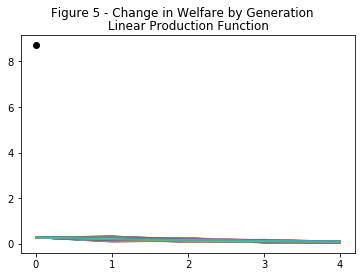

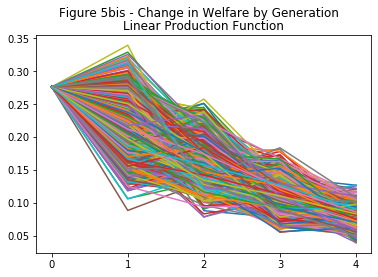

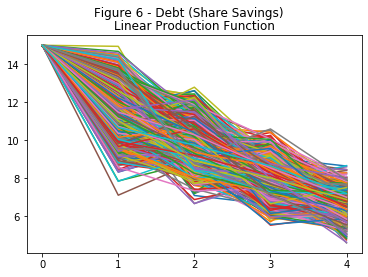

In [7]:
#Print results
#############################

wdL  = VbL  - VbL0

#############################
#Plot results
#############################

aL=round(np.percentile(wdL, 50, axis=0)[0],3)*100
wdbL = wdL[:,1:]
wdbL=wdbL*100
wdtL = np.transpose(wdbL)
plt.xticks([0,1,2,3,4])
plt.plot(wdtL)
plt.plot(0, aL, 'o', color='black')
plt.suptitle('Figure 5 - Change in Welfare by Generation')
plt.title('Linear Production Function')
#plt.savefig('pol3L.png')
plt.show()


#############################
#Plot results
#############################

wdbL = wdL[:,1:]
wdbL=wdbL*100
wdtL = np.transpose(wdbL)
plt.xticks([0,1,2,3,4])
plt.plot(wdtL)
plt.suptitle('Figure 5bis - Change in Welfare by Generation')
plt.title('Linear Production Function')
#plt.savefig('pol3L.png')
plt.show()

#############################
#Plot results
#############################

aS0L = tauaS
aSIbL = aSIL[:,2:]
aSIbL = np.insert(aSIbL, 0, aS0L, axis=1)
aSIbL=aSIbL*100
aSItL=aSIbL.transpose()
plt.xticks([0,1,2,3,4,5])
plt.plot(aSItL)
plt.suptitle('Figure 6 - Debt (Share Savings)')
plt.title('Linear Production Function')
#plt.savefig('pol3debtL.png')
plt.show()


### Cobb-Douglas Production Function

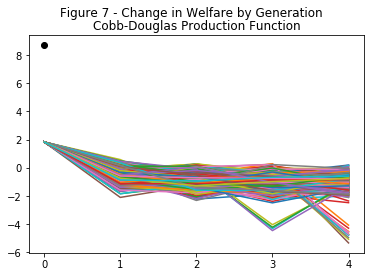

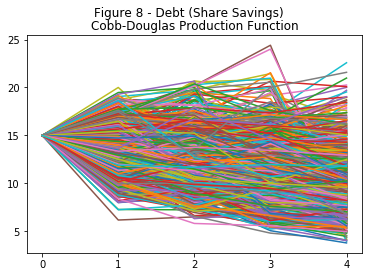

In [8]:
# More results
#############################

wdCD  = VbCD  - VbCD0

#############################
#Plot results
#############################

aCD=round(np.percentile(wdCD, 50, axis=0)[0],3)*100
wdbCD = wdCD[:,1:]
wdbCD=wdbCD*100
wdtCD = np.transpose(wdbCD)
plt.xticks([0,1,2,3,4])
plt.plot(wdtCD)
plt.plot(0, aCD, 'o', color='black')
plt.suptitle('Figure 7 - Change in Welfare by Generation')
plt.title('Cobb-Douglas Production Function')
#plt.savefig('pol3L.png')
plt.show()

#############################
#Plot results
#############################

aS0CD = tauaS
aSIbCD = aSICD[:,2:]
aSIbCD = np.insert(aSIbCD, 0, aS0CD, axis=1)
aSIbCD=aSIbCD*100
aSItCD=aSIbCD.transpose()
plt.xticks([0,1,2,3,4,5])
plt.plot(aSItCD)
plt.suptitle('Figure 8 - Debt (Share Savings)')
plt.title('Cobb-Douglas Production Function')
#plt.savefig('pol3debtCD.png')
plt.show()


In [9]:
# Elapsed time
end = time.time()
print(" \n Time: %0.4f \n" % (end - start))

 
 Time: 49.5246 

